# Python для DataScience
## Курсовая работа

В этой курсовой работе мы будем обучать модель, предсказывающую цены на квартиры

In [1]:
from urllib import request
from os.path import isfile

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso
from sklearn.manifold import TSNE
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBRegressor
import pickle

from multiprocessing import Pool

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_model_r2(X_train, y_train, X_test, y_test, model):
    """Запускает целевую модель и выдает среднеквадратичное отклонение r2"""
    model.fit(X_train, y_train)
    y_pred=model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    return r2

### Загрузка данных

Скачаем датасеты:

In [3]:
train_url = 'https://uploads.hb.cldmail.ru/asset/1381522/attachment/302b3d11658ce764f4e8655292566e11.csv'
test_url = 'https://uploads.hb.cldmail.ru/asset/1381521/attachment/f74867a92dc85932950369d8d31db3b0.csv'

train_path = 'train.csv'
test_path = 'test.csv'

if not isfile(train_path):
    request.urlretrieve(train_url, train_path)
if not isfile(test_path):
    request.urlretrieve(test_url, test_path)

In [4]:
train = pd.read_csv(train_path).set_index('Id')

### Разбивка данных
Разобьем датафрейм на тестовый и контрольный

In [5]:
data, valid = train_test_split(train, test_size=0.25, random_state=42)

### Очистка данных
Давайте проанализируем датасет

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7500 entries, 13295 to 2135
Data columns (total 19 columns):
DistrictId       7500 non-null int64
Rooms            7500 non-null float64
Square           7500 non-null float64
LifeSquare       5906 non-null float64
KitchenSquare    7500 non-null float64
Floor            7500 non-null int64
HouseFloor       7500 non-null float64
HouseYear        7500 non-null int64
Ecology_1        7500 non-null float64
Ecology_2        7500 non-null object
Ecology_3        7500 non-null object
Social_1         7500 non-null int64
Social_2         7500 non-null int64
Social_3         7500 non-null int64
Healthcare_1     3886 non-null float64
Helthcare_2      7500 non-null int64
Shops_1          7500 non-null int64
Shops_2          7500 non-null object
Price            7500 non-null float64
dtypes: float64(8), int64(8), object(3)
memory usage: 1.1+ MB


In [7]:
data.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,7500.000000,7500.000000,7500.000000,5906.000000,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000,3886.000000,7500.000000,7500.000000,7500.000000
mean,50.441733,1.887600,56.262165,37.438158,6.417333,8.502800,12.634400,4.658736e+03,0.117437,24.736133,5361.467467,8.027733,1129.527535,1.309467,4.259200,214000.951964
std,43.700617,0.840234,20.337193,98.726068,32.870226,5.236619,6.833644,2.315178e+05,0.118195,17.627507,4021.616228,23.825236,1015.975294,1.488576,4.819673,92539.924814
min,0.000000,0.000000,2.377248,0.370619,0.000000,1.000000,0.000000,1.912000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,19.000000,1.000000,41.748189,22.838608,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,325.000000,0.000000,1.000000,153980.839919
50%,35.000000,2.000000,52.539538,32.837997,6.000000,7.000000,14.000000,1.977000e+03,0.072158,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,75.000000,2.000000,65.980391,45.069982,9.000000,12.000000,17.000000,2.001000e+03,0.194489,36.000000,7287.000000,5.000000,1547.750000,2.000000,6.000000,249035.045145
max,209.000000,19.000000,604.705972,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,627525.072788


Давайте разберем датасет по пунктам

#### Оценим признак `Rooms`

In [8]:
data['Rooms'].describe()

count    7500.000000
mean        1.887600
std         0.840234
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max        19.000000
Name: Rooms, dtype: float64

In [9]:
data['Rooms'].value_counts()

2.0     2918
1.0     2785
3.0     1667
4.0      110
5.0       12
0.0        5
19.0       1
10.0       1
6.0        1
Name: Rooms, dtype: int64

Заменим выбросы ( rooms == 0 ) и ( rooms > 5 ) на среднее значение по выборке

In [10]:
rooms_mean = data.Rooms.mean()

def fill_rooms_with_mean(data):
    data[data.Rooms > 5]['Rooms'] = rooms_mean
    data[data.Rooms < 1]['Rooms'] = rooms_mean
    return data
    

rooms_cut = fill_rooms_with_mean(data)

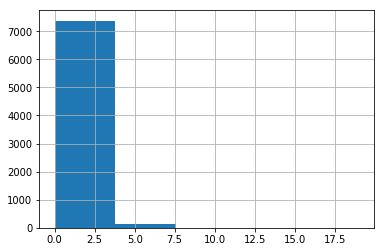

In [11]:
rooms_cut.Rooms.hist(bins=5)

#### Оценим признак `Square`

In [12]:
data['Square'].describe()

count    7500.000000
mean       56.262165
std        20.337193
min         2.377248
25%        41.748189
50%        52.539538
75%        65.980391
max       604.705972
Name: Square, dtype: float64

Давайте выкинем записи в которых признак Square < 10

In [13]:
def drop_bad_square(ds):
    bad_square = data[data.Square < 10]
    if bad_square.shape[0] > 0:
        ds.drop(bad_square.index, inplace=True)       
    return ds

In [14]:
# data = drop_bad_square(data)

#### Оценим признак `HouseYear`

In [15]:
data.HouseYear.describe()

count    7.500000e+03
mean     4.658736e+03
std      2.315178e+05
min      1.912000e+03
25%      1.974000e+03
50%      1.977000e+03
75%      2.001000e+03
max      2.005201e+07
Name: HouseYear, dtype: float64

In [16]:
data['HouseYear'].sort_values().tail(5)

Id
6731         2020
6845         2020
9303         2020
11607        4968
10814    20052011
Name: HouseYear, dtype: int64

Видим явно выпадающие значения [4968, 20052011]

Заменим 4968 на 1968, 20052011 на 2008

In [17]:
data.loc[data.HouseYear == 4968, 'HouseYear'] = 1968
data.loc[data.HouseYear == 20052011, 'HouseYear'] = 2008

Ради интереса, построим гистограмму

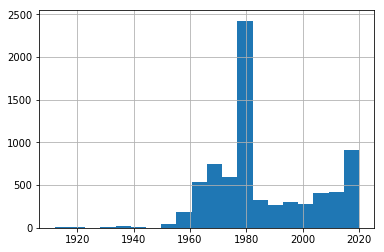

In [18]:
data['HouseYear'].hist(bins=20);

Примечательно - большинство квартир в домах построенных на рубеже конца 1970х - начала 1980х

#### Оценим признак `LifeSquare`
Найдем те записи, где `LifeSquare` > `Square`

In [19]:
data[data.LifeSquare > data.Square].shape[0]

366

Выходит, что для 4% записей жилая площадь больше общей площади, что некорректно. Давайте оценим зависимость площадей.

(10, 250)

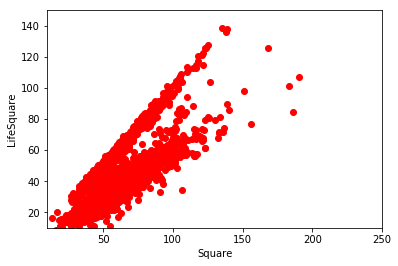

In [20]:
plt.plot(
    data['Square'],
    data['LifeSquare'],
    'ro'
)
plt.xlabel('Square')
plt.ylabel('LifeSquare')
plt.ylim(10,150)
plt.xlim(10,250)

Видно, что зависимость линейна. Давайте попробуем представить это как линейную функцию

In [21]:
def get_linargs(x,y):
    b1 = (np.mean(x * y) - np.mean(x) * np.mean(y)) / (np.mean(x ** 2) - np.mean(x) ** 2)
    b0 = np.mean(y) - b1 * np.mean(x)
    return b1, b0

(10, 250)

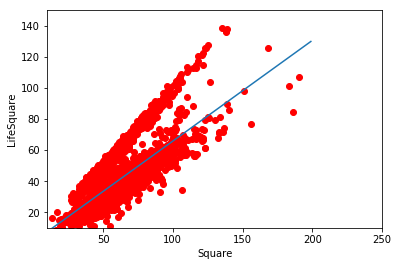

In [22]:
b1, b0 = get_linargs(data['Square'], data['LifeSquare'])

x = np.arange(10,200, 1)

plt.plot(
    data['Square'],
    data['LifeSquare'],
    'ro'
)
plt.plot(x, b1*x + b0)
plt.xlabel('Square')
plt.ylabel('LifeSquare')
plt.ylim(10,150)
plt.xlim(10,250)

Вполне линейная зависимость. Давайте заполним ей пустые значения.

In [23]:
def fill_na_life_square(data):
    lifeSquare_predicted = data['Square'] * b1 + b0
    data['LifeSquare'].fillna(lifeSquare_predicted, inplace=True)
    return data

In [24]:
data = fill_na_life_square(data)

#### Оценим признак `DistrictId`
Начнем с гистограммы

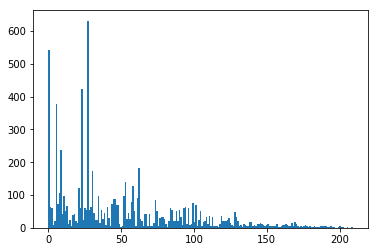

In [25]:
plt.hist(
    data['DistrictId'],
    bins=data['DistrictId'].nunique()
);

Это ничего не дало. Попробуем взять среднюю цену за квадратный метр по району

In [26]:
data['price_per_square'] = data.Price / data.Square
price_per_square_by_District = data.groupby(
    ['DistrictId']
)['price_per_square'].mean().reset_index().rename(
    columns={'price_per_square': 'District_square_price'})

Добавим признак `District_square_price` к датасету

In [27]:
def add_distr_sq_price(df):
    dqp_mean = price_per_square_by_District['District_square_price'].mean()
    df.reset_index(inplace=True)
    df = pd.merge(df,price_per_square_by_District,on='DistrictId',how='left')
    df['District_square_price'] = df['District_square_price'].fillna(dqp_mean)
    
    if 'price_per_square' in df.keys():
        df.drop(['price_per_square'], axis=1, inplace=True)

    return df.drop(['DistrictId'], axis=1).set_index('Id')

In [28]:
# data = add_distr_sq_price(data)

#### Оценим признаки `Floor` `HouseFloor`
Очистим выпадающие записи

In [29]:
floor_data = data[['Floor','HouseFloor']]
floor_data['HouseFloor'].value_counts()

17.0     1749
9.0      1044
12.0      797
5.0       764
14.0      476
16.0      423
1.0       388
25.0      287
22.0      257
0.0       195
24.0      127
8.0       110
10.0      109
15.0       95
4.0        95
3.0        92
19.0       90
20.0       84
18.0       65
6.0        43
7.0        36
2.0        36
23.0       27
21.0       25
11.0       22
13.0       18
30.0       18
27.0        5
40.0        5
32.0        4
37.0        2
99.0        2
39.0        2
31.0        1
29.0        1
44.0        1
47.0        1
36.0        1
48.0        1
117.0       1
28.0        1
Name: HouseFloor, dtype: int64

Давайте посмотрим на дома выше 30 этажей

In [30]:
def create_first_last_floor_columns(data):
    data['is_first_floor'] = (data.Floor == 1).astype(int)
    data['is_last_floor'] = (data.Floor >= data.HouseFloor).astype(int)
    return data

In [31]:
# data = create_first_last_floor_columns(data)

#### KitchenSquare
25% данных о размерах кухни составляют 1, что не похоже на правду. 
Если это так, то данным признаком следует пренебречь, так как он крайне неточен

Для начала, построим гистограмму распределения квартир по площадям кухни

In [32]:
data.KitchenSquare.describe()

count    7500.000000
mean        6.417333
std        32.870226
min         0.000000
25%         1.000000
50%         6.000000
75%         9.000000
max      2014.000000
Name: KitchenSquare, dtype: float64

In [33]:
data.loc[data.KitchenSquare == 2014, 'KitchenSquare'] = 1

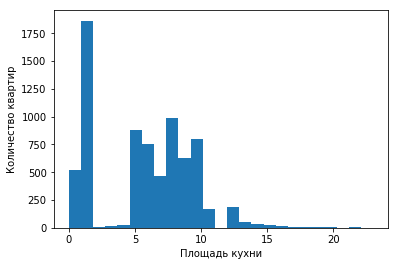

In [34]:
plt.hist(
    data['KitchenSquare'].loc[data.KitchenSquare < 25], 
    bins=25
)

plt.xlabel('Площадь кухни')
plt.ylabel('Количество квартир')
plt.show();

Давайте вычислим среднюю площадь квартиры, имеющую кухню площадью 1, а также общий процент таких квартир среди всей выборки

In [35]:
square_with_tiny_kitchen = data.loc[data.KitchenSquare <= 1]['Square'].loc[data.Square < 100]

In [36]:
square_with_tiny_kitchen.mean(), square_with_tiny_kitchen.count() / data['Square'].count()

(57.89329212823305, 0.30706666666666665)

_Я пробовал корректировать этот признак, искать закономерности, даже строить регрессиннные модели, но получал r2 близкий к нулю.
Так что оставим признак как есть._

#### Healthcare_1
48% записей не имеют значения в признаке  `Healthcare_1`. 
Давайте развернем датасет - возьмем `Healthcare_1` в качестве целевого признака и построим модель для вычисления пустых значений

In [37]:
# hc_ds = pd.get_dummies(data).drop(['Price'], axis=1)
# health1_train = hc_ds[data.Healthcare_1.notnull()]
# health1_test = hc_ds[data.Healthcare_1.isna()].drop(['Healthcare_1'], axis=1)

In [38]:
# # Разобьем датасет
# X_train, X_test, y_train, y_test = train_test_split(
#     health1_train.drop(['Healthcare_1'], axis=1), 
#     health1_train['Healthcare_1'], 
#     test_size=0.33, random_state=42)

# # Используем GridSearchCV для нахождения оптимального дерева решений
# decision_tree = GridSearchCV(estimator=DecisionTreeRegressor(random_state=42),
#                    param_grid=[{'max_depth': np.arange(2,40)}],
#                    scoring='r2',
#                    n_jobs=-1,
#                    cv=5)

# decision_tree.fit(X_train, y_train);
# y_pred = decision_tree.predict(X_test)
# test_r2 = r2_score(y_test, y_pred)

# print(f'Оптимальная глубина дерева: {decision_tree.best_params_["max_depth"]}')
# print(f'train r2: {decision_tree.best_score_:.4f}')
# print(f'test  r2: {test_r2:.4f}')
          

In [39]:
# health1_test['Healthcare_1'] = decision_tree.predict(health1_test)

In [40]:
# data.update(health1_test)

_В итоге, я словил переобучение и отказалсся от этой идеи_

### Модификация датасетов
Напишем функцию которая чистит датасет, добавляет признаки

In [41]:
def prepare_dataset(ds, is_train=False):
    """Готовит датает, очищая, добавляя признаки"""

    # почистить Rooms
    fill_rooms_with_mean(ds)
    
    # ! Выкинуть Square Только в тестовом
    if is_train:
        ds = drop_bad_square(ds)
        
    # почистить HouseYear
    # По датасетам
   
    
    # нормализовать LifeSquare
    ds = fill_na_life_square(ds)
        
    # Заменить DistrictId на District_square_price
    ds = add_distr_sq_price(ds)

    # добавить признаки is_first_floor is_last_floor
    ds = create_first_last_floor_columns(ds)
    
    
    
    # убрать HealthSquare
    ds.drop(['Healthcare_1'], axis=1, inplace=True)
    
    # get_dummies
    ds = pd.get_dummies(ds)
    
    if 'Price' in ds.keys():
        y = ds['Price']
        ds.drop(['Price'], axis=1, inplace=True)
        return ds, y
    else:
        return ds

In [42]:
# ds = data

# ds = drop_bad_square(ds)

# ds = fill_na_life_square(ds)

# ds = add_distr_sq_price(ds)

# ds = create_first_last_floor_columns(ds)

# ds.drop(['Healthcare_1'], axis=1, inplace=True)

# ds = pd.get_dummies(ds)

# 'index' in ds.keys()

### Обучение моделей и их применение

#### Разбиение на тренировочные и тестовые

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7500 entries, 13295 to 2135
Data columns (total 20 columns):
DistrictId          7500 non-null int64
Rooms               7500 non-null float64
Square              7500 non-null float64
LifeSquare          7500 non-null float64
KitchenSquare       7500 non-null float64
Floor               7500 non-null int64
HouseFloor          7500 non-null float64
HouseYear           7500 non-null int64
Ecology_1           7500 non-null float64
Ecology_2           7500 non-null object
Ecology_3           7500 non-null object
Social_1            7500 non-null int64
Social_2            7500 non-null int64
Social_3            7500 non-null int64
Healthcare_1        3886 non-null float64
Helthcare_2         7500 non-null int64
Shops_1             7500 non-null int64
Shops_2             7500 non-null object
Price               7500 non-null float64
price_per_square    7500 non-null float64
dtypes: float64(9), int64(8), object(3)
memory usage: 1.5+ MB


In [44]:
X_train, y_train = prepare_dataset(data, is_train=True)
X_test, y_test = prepare_dataset(valid, is_train=False)

In [45]:
X_train.tail(1)

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,...,Shops_1,District_square_price,is_first_floor,is_last_floor,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
Id,,,,,,,,,,,,,,,,,,,,,
2135,2.0,88.364677,42.822492,11.0,12,16.0,1993,0.035145,42,9292,...,3,4637.013661,0,0,0,1,0,1,0,1


In [46]:
for i in X_train.keys():
    if i not in X_test.keys():
        print(i)

In [47]:
# X_train, X_test, y_train, y_test = split_data(ds, 'Price')

Стандартизируем значения:

In [48]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.keys())
X_test_scaled = pd.DataFrame(
    scaler.fit_transform(X_test),
    columns=X_test.keys())

#### Линейная регрессия
Обучим модель линейной регрессии

In [49]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
get_model_r2(X_train_scaled, y_train, X_test_scaled, y_test, lr)

0.5661174517776062

In [50]:
X_train.head(5)

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,...,Shops_1,District_square_price,is_first_floor,is_last_floor,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
Id,,,,,,,,,,,,,,,,,,,,,
13295,1.0,39.248800,26.408302,0.0,9,17.0,1977,0.007122,1,264,...,1,3292.616591,0,0,0,1,0,1,0,1
3756,2.0,56.053580,33.929772,8.0,8,12.0,1986,0.300323,52,10311,...,9,4442.352118,0,0,0,1,0,1,0,1
15429,1.0,41.009788,23.960289,8.0,3,14.0,1997,0.090799,74,19083,...,15,4146.961126,0,0,0,1,0,1,0,1
7238,2.0,63.640480,58.149243,1.0,3,1.0,1977,0.161532,25,5648,...,4,3276.010175,0,1,0,1,0,1,0,1
13604,1.0,49.327912,20.992250,12.0,15,23.0,2008,0.246032,22,3151,...,3,4488.447400,0,0,0,1,1,0,0,1


In [51]:
X_train.shape, X_test.shape

((7493, 22), (2500, 22))

#### Градиентный бустинг
Не смотря на то, что градиентный бустинг еще не проходили - он активно обсуждается на всех чемпионатах как лучшее средство до нейронных сетей. Я буду использовать его для получения итогового результата, однако пройдусь и по пройденным алгоритмам

In [51]:
xgb = XGBRegressor(colsample_bytree=0.5, gamma=0.0, 
                             learning_rate=0.005, max_depth=7, 
                             min_child_weight=0.5, n_estimators=5800,
                             reg_alpha=0.9, reg_lambda=0.99,
                             subsample=0.99,seed=42, silent=1,
                             random_state=42)

In [ ]:
# ds = pd.get_dummies(data).drop(['Healthcare_1'], axis=1).set_index('Id')
# get_model_r2(X_train, y_train, X_test, y_test, xgb)
# 0.7548214320215614

In [ ]:
# ds = pd.get_dummies(data).set_index('Id')
# get_model_r2(X_train, y_train, X_test, y_test, xgb)
# 0.7556017998096649

In [52]:
get_model_r2(X_train, y_train, X_test, y_test, xgb)

0.7356707559382709

In [53]:
!telegram-send "OK!"

Отлично, теперь посмотрим на тестовый датасет

In [55]:
test = pd.read_csv(test_path).set_index('Id')

In [56]:
test.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,51.279200,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,44.179466,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


#### Rooms

In [57]:
test[test.Rooms > 5]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
10793,23,6.0,110.750226,NaN,0.0,2,2.0,2015,0.014073,B,B,2,475,0,NaN,0,0,B
4058,27,6.0,223.453689,104.113552,16.0,2,2.0,2017,0.041116,B,B,53,14892,4,NaN,1,4,B
1435,111,17.0,52.866107,32.528342,8.0,15,17.0,1987,0.093443,B,B,23,4635,5,3300.0,2,4,B


In [61]:
test.loc[1435]['Rooms'] = 1

#### Примение T-SNE
Попробуем перебрать параметр `learning_rates` чтобы найти идеальные условия для кластеризации

In [326]:
def train_tsne(lr):
    tsne = TSNE(n_components=2, learning_rate=lr, random_state=42)
    return tsne.fit_transform(X_train_scaled)

def get_good_tsne():
    learning_rates = [10, 50, 100, 150, 300, 500, 800, 1000]
    tsne_list = dict()
    with Pool() as p:  
        tsne_list = p.map(train_tsne, learning_rates)
    return dict(zip(learning_rates, tsne_list))

In [327]:
tsne_dict = get_good_tsne()

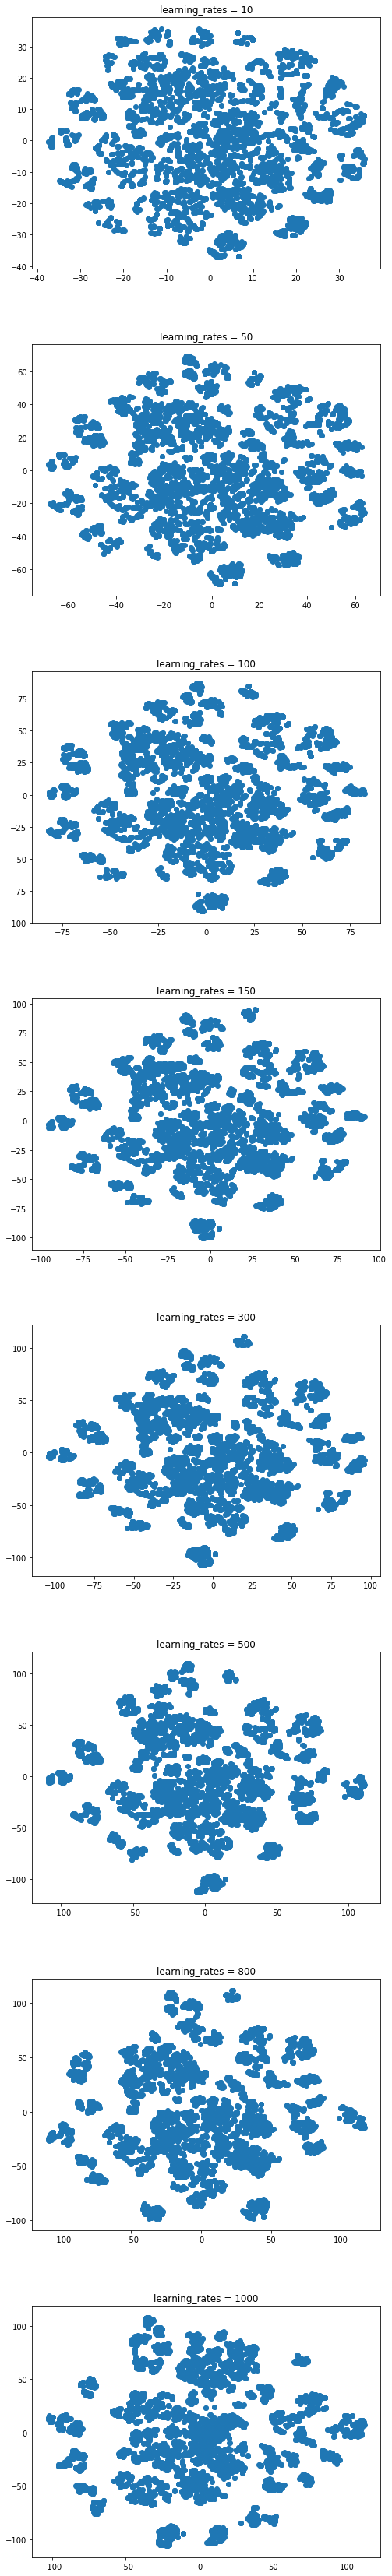

In [328]:
fig, ax = plt.subplots(len(tsne_dict),1)
fig.set_figwidth(8)
fig.set_figheight(60)
fig.subplots_adjust(wspace=0.3, hspace=0.3)

i = 0
for lr, tsne_array in tsne_dict.items():
    ax[i].scatter(tsne_array[:, 0], tsne_array[:, 1])
    ax[i].set_title(f'learning_rates = {lr}')
    i += 1

In [329]:
!telegram-send "OK!"

По полученным графиком я не вижу явной возможности для кластеризации, так что исключим подобные алгоритмы.

Но давайте попробуем разбить на 3 кластера:

In [330]:
from sklearn.cluster import KMeans

In [334]:
kmeans = KMeans(n_clusters=2)
labels_train = kmeans.fit_predict(X_train_scaled)
pd.value_counts(labels_train)

0    5356
1    2635
dtype: int64

In [335]:
labels_train = kmeans.predict(X_train_scaled)

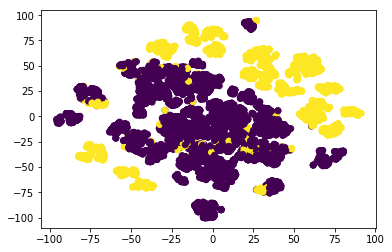

In [336]:
plt.scatter(
    tsne_dict[150][:, 0],
    tsne_dict[150][:, 1],
    c=labels_train
);

Так себе разбиение на кластеры, если честно

#### PCA (Метод главных компонент)
Попробуем выявить наиболее значимые признаки

In [337]:
print("Оценка линейной регрессии при разном количестве взятых признаков:")
for n in range(1,X_train.shape[1] + 1):
    pca = PCA(n_components=n, random_state=42)
    X_train_mc = pca.fit_transform(X_train_scaled)
    X_test_mc = pca.transform(X_test_scaled)
    lr = LinearRegression()
    r2 = get_model_r2(X_train_mc, y_train, X_test_mc, y_test, lr)
    
    print(f'при n = {n}, \t r2 = {r2:.4f},\tacc = {np.sum(pca.explained_variance_ratio_[:n])}')

Оценка линейной регрессии при разном количестве взятых признаков:
при n = 1, 	 r2 = 0.0979,	acc = 0.15585729925364925
при n = 2, 	 r2 = 0.1513,	acc = 0.25670277490732074
при n = 3, 	 r2 = 0.1526,	acc = 0.35266896777162543
при n = 4, 	 r2 = 0.2693,	acc = 0.4371101663008442
при n = 5, 	 r2 = 0.3732,	acc = 0.5194225534207129
при n = 6, 	 r2 = 0.4521,	acc = 0.5952292082675444
при n = 7, 	 r2 = 0.4748,	acc = 0.6583329620793171
при n = 8, 	 r2 = 0.4871,	acc = 0.7153281014206989
при n = 9, 	 r2 = 0.4845,	acc = 0.7604974922927908
при n = 10, 	 r2 = 0.5276,	acc = 0.8027501822807257
при n = 11, 	 r2 = 0.5273,	acc = 0.843968912705714
при n = 12, 	 r2 = 0.5354,	acc = 0.8826754192550197
при n = 13, 	 r2 = 0.5722,	acc = 0.9171178616803047
при n = 14, 	 r2 = 0.5976,	acc = 0.9433987424072894
при n = 15, 	 r2 = 0.6073,	acc = 0.9666385392807446
при n = 16, 	 r2 = 0.6091,	acc = 0.9797484675368331
при n = 17, 	 r2 = 0.6095,	acc = 0.9904145415001473
при n = 18, 	 r2 = 0.6121,	acc = 0.9984308626290241
при n

Мы видим что лучший результат достигается при $n = 19$

In [198]:
pca = PCA(n_components=19, random_state=42)

X_train_mc = pca.fit_transform(X_train_scaled)

X_test_mc = pca.transform(X_test_scaled)

get_model_r2(X_train_mc, y_train, X_test_mc, y_test, lr)

0.672546719760197

#### Дерево решений

In [199]:
decision_tree = GridSearchCV(estimator=DecisionTreeRegressor(random_state=42),
                   param_grid=[{'max_depth': np.arange(2,40)}],
                   scoring='r2',
                   n_jobs=-1,
                   cv=5)

In [200]:
decision_tree.fit(X_train_mc, y_train);

In [201]:
print(f'best max_depth: {decision_tree.best_params_["max_depth"]}, \tbest r2:{decision_tree.best_score_}')

best max_depth: 5, 	best r2:0.6601146607476543


In [202]:
y_pred=decision_tree.predict(X_test_mc)
r2_score(y_test, y_pred)

0.487934530607555

In [203]:
def do_tree(max_depth):
    model = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
    return get_model_r2(X_train_mc, y_train, X_test_mc, y_test, model)
    
def best_tree_score():
    max_depths = np.arange(2,40)
    with Pool() as p:  
        tree_score_list = p.map(do_tree, max_depths)
    return dict(zip(max_depths, tree_score_list))

In [204]:
tree_dict = best_tree_score()

In [205]:
print("Оценка дерева решений с переменной глубиной ")
for depth, r2 in tree_dict.items():
    print(f'max_depth: {depth} \t r2: {r2:.4f}')

Оценка дерева решений с переменной глубиной 
max_depth: 2 	 r2: 0.4201
max_depth: 3 	 r2: 0.4703
max_depth: 4 	 r2: 0.4462
max_depth: 5 	 r2: 0.4879
max_depth: 6 	 r2: 0.5003
max_depth: 7 	 r2: 0.4466
max_depth: 8 	 r2: 0.3866
max_depth: 9 	 r2: 0.4402
max_depth: 10 	 r2: 0.3449
max_depth: 11 	 r2: 0.3572
max_depth: 12 	 r2: 0.3681
max_depth: 13 	 r2: 0.3125
max_depth: 14 	 r2: 0.2863
max_depth: 15 	 r2: 0.2922
max_depth: 16 	 r2: 0.2870
max_depth: 17 	 r2: 0.2337
max_depth: 18 	 r2: 0.3253
max_depth: 19 	 r2: 0.2894
max_depth: 20 	 r2: 0.2419
max_depth: 21 	 r2: 0.2826
max_depth: 22 	 r2: 0.2599
max_depth: 23 	 r2: 0.2925
max_depth: 24 	 r2: 0.2754
max_depth: 25 	 r2: 0.2397
max_depth: 26 	 r2: 0.2559
max_depth: 27 	 r2: 0.2813
max_depth: 28 	 r2: 0.2695
max_depth: 29 	 r2: 0.2671
max_depth: 30 	 r2: 0.2755
max_depth: 31 	 r2: 0.3044
max_depth: 32 	 r2: 0.3026
max_depth: 33 	 r2: 0.2776
max_depth: 34 	 r2: 0.2695
max_depth: 35 	 r2: 0.2823
max_depth: 36 	 r2: 0.2830
max_depth: 37 	 r2

In [62]:
!telegram-send 'Проверяй!'

Config not found
Please run: telegram-send --configure


При вычислении регресси деревом решений глубины 6 мы получаем точность $r2 = 0.54$

#### Случайный лес

In [63]:
decision_tree = GridSearchCV(estimator=DecisionTreeRegressor(random_state=42),
                   param_grid=[{'max_depth': np.arange(2,40)}],
                   scoring='r2',
                   n_jobs=-1,
                   cv=5)

In [64]:
def do_forest(max_depth):
    model = RandomForestRegressor(n_estimators=1000, max_depth=max_depth, random_state=42)
    return get_model_r2(X_train_mc, y_train, X_test_mc, y_test, model)
    
def best_forest_score():
    max_depths = np.arange(15,31)
    with Pool() as p:  
        forest_score_list = p.map(do_forest, max_depths)
    return dict(zip(max_depths, forest_score_list))

In [65]:
forest_dict = best_forest_score()

In [66]:
!telegram-send "Я сделялъ"

Config not found
Please run: telegram-send --configure


In [67]:
print("Оценка случайных деревьев с переменной глубиной ")
for depth, r2 in forest_dict.items():
    print(f'max_depth: {depth} \t r2: {r2:.4f}')

Оценка случайных деревьев с переменной глубиной 
max_depth: 15 	 r2: 0.7093
max_depth: 16 	 r2: 0.7094
max_depth: 17 	 r2: 0.7089
max_depth: 18 	 r2: 0.7089
max_depth: 19 	 r2: 0.7089
max_depth: 20 	 r2: 0.7095
max_depth: 21 	 r2: 0.7086
max_depth: 22 	 r2: 0.7094
max_depth: 23 	 r2: 0.7087
max_depth: 24 	 r2: 0.7085
max_depth: 25 	 r2: 0.7086
max_depth: 26 	 r2: 0.7093
max_depth: 27 	 r2: 0.7089
max_depth: 28 	 r2: 0.7089
max_depth: 29 	 r2: 0.7089
max_depth: 30 	 r2: 0.7092


При вычислении регрессии случайным лесом глубиной 23 мы получаем точность $r2 = 0.7072$

#### Расширенный случайный лес
будем использовать также `GredSearchCV`

In [68]:
parametrs = [{'n_estimators': [150,200,250,500,750,1000],
              'max_features': ["auto", "sqrt", "log2"],
              'max_depth': np.arange(10,25)}]

In [206]:
clf = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                   param_grid=parametrs,
                   scoring='r2',
                   n_jobs=-1,
                   cv=5)

In [207]:
clf.fit(X_train_mc, y_train)

KeyboardInterrupt: 

In [71]:
clf.best_params_, clf.best_score_

({'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 200},
 0.790034250633083)

Наилучшие парамедры для случайного леса:

'max_depth': 21, 'max_features': 'sqrt', 'n_estimators': 750

r2 = 0.719

In [84]:
y_pred = clf.predict(X_test_mc)
test_r2 = r2_score(y_test, y_pred)
test_r2

0.7125869949316297

#### L1, L2 регуляризация

In [80]:
test = pd.read_csv(test_path)

In [81]:
data.Helthcare_2.value_counts()

0.0    2928
1.0    1257
3.0     320
5.0     175
2.0     102
Name: Helthcare_2, dtype: int64